# Circle radius test
Learn the function $f: \mathbb{R}^{12} \rightarrow \mathbb{R}$ where $f:\bf{x} \mapsto |x|$ with a deep neural network and compute the mutual information changes between the input, the different layer outputs and the output.

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.optimizers import Adam

/home/mariosk/anaconda2/envs/ipykernel_py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [43]:
def plot_learning_curve(fitting_history):
    plt.clf()
    plt.figure(figsize=(10, 10))

    plt.subplot(2,1,1)
    plt.plot(fitting_history['loss'], color='steelblue')
    plt.plot(fitting_history['val_loss'], color='orange')
    plt.legend(['Training loss', 'Testing loss'])

    plt.subplot(2,1,2)
    plt.plot(fitting_history['acc'], color='steelblue')
    plt.plot(fitting_history['val_acc'], color='orange')
    plt.legend(['Training accuracy', 'Testing accuracy'])

    plt.show()

## Define function and generate random samples

In [31]:
def f(x):
    return np.where(np.sqrt(np.sum(x * x)) > 2, 1, 0)

In [54]:
np.random.seed(42)
X_train = np.random.uniform(-1, 1, size=[100000, 12])
Y_train = np.apply_along_axis(f, 1, X_train)

X_test = np.random.uniform(-1, 1, size=[10000, 12])
Y_test = np.apply_along_axis(f, 1, X_test)

## Build a feed forward neural network

In [60]:
ffnn = Sequential([
    Dense(48, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(24, activation='relu'),
    Dense(12, activation='relu'),
    Dense(10, activation='relu'),
    Dense(8, activation='relu'),
    Dense(4, activation='relu'),
    Dense(2, activation='sigmoid')
])

ffnn.compile(metrics=['accuracy'], optimizer=Adam(), loss='categorical_crossentropy')

In [61]:
number_of_epochs = 500
batch_size = 1000

ffnn_fitting = ffnn.fit(
    X_train, 
    to_categorical(Y_train),
    validation_data=(X_test, to_categorical(Y_test)),
    epochs=number_of_epochs,
    batch_size=batch_size)

Train on 100000 samples, validate on 10000 samples
Epoch 1/500
100000/100000 [==============================] - 1s 7us/step - loss: 0.6466 - acc: 0.6143 - val_loss: 0.5343 - val_acc: 0.7766
Epoch 2/500
100000/100000 [==============================] - 0s 5us/step - loss: 0.3371 - acc: 0.8720 - val_loss: 0.2366 - val_acc: 0.8976
Epoch 3/500
100000/100000 [==============================] - 1s 5us/step - loss: 0.2146 - acc: 0.9050 - val_loss: 0.2141 - val_acc: 0.9030
Epoch 4/500
100000/100000 [==============================] - 0s 5us/step - loss: 0.1965 - acc: 0.9132 - val_loss: 0.1993 - val_acc: 0.9105
Epoch 5/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.1847 - acc: 0.9181 - val_loss: 0.1925 - val_acc: 0.9128
Epoch 6/500
100000/100000 [==============================] - 1s 6us/step - loss: 0.1777 - acc: 0.9214 - val_loss: 0.1823 - val_acc: 0.9220
Epoch 7/500
100000/100000 [==============================] - 0s 5us/step - loss: 0.1718 - acc: 0.9245 - val_loss: 0

100000/100000 [==============================] - 1s 5us/step - loss: 0.1025 - acc: 0.9562 - val_loss: 0.1351 - val_acc: 0.9431
Epoch 60/500
100000/100000 [==============================] - 0s 5us/step - loss: 0.1023 - acc: 0.9563 - val_loss: 0.1273 - val_acc: 0.9447
Epoch 61/500
100000/100000 [==============================] - 1s 5us/step - loss: 0.1028 - acc: 0.9554 - val_loss: 0.1260 - val_acc: 0.9453
Epoch 62/500
100000/100000 [==============================] - 1s 5us/step - loss: 0.1035 - acc: 0.9552 - val_loss: 0.1333 - val_acc: 0.9415
Epoch 63/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.1007 - acc: 0.9563 - val_loss: 0.1270 - val_acc: 0.9448
Epoch 64/500
100000/100000 [==============================] - 1s 6us/step - loss: 0.1028 - acc: 0.9556 - val_loss: 0.1352 - val_acc: 0.9413
Epoch 65/500
100000/100000 [==============================] - 1s 5us/step - loss: 0.1008 - acc: 0.9565 - val_loss: 0.1328 - val_acc: 0.9440
Epoch 66/500
100000/100000 [=====

100000/100000 [==============================] - 0s 5us/step - loss: 0.0889 - acc: 0.9614 - val_loss: 0.1272 - val_acc: 0.9473
Epoch 118/500
100000/100000 [==============================] - 1s 5us/step - loss: 0.0882 - acc: 0.9620 - val_loss: 0.1230 - val_acc: 0.9475
Epoch 119/500
100000/100000 [==============================] - 0s 5us/step - loss: 0.0876 - acc: 0.9621 - val_loss: 0.1190 - val_acc: 0.9509
Epoch 120/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0880 - acc: 0.9618 - val_loss: 0.1168 - val_acc: 0.9518
Epoch 121/500
100000/100000 [==============================] - 0s 5us/step - loss: 0.0862 - acc: 0.9630 - val_loss: 0.1197 - val_acc: 0.9494
Epoch 122/500
100000/100000 [==============================] - 1s 5us/step - loss: 0.0869 - acc: 0.9627 - val_loss: 0.1202 - val_acc: 0.9499
Epoch 123/500
100000/100000 [==============================] - 0s 5us/step - loss: 0.0876 - acc: 0.9621 - val_loss: 0.1181 - val_acc: 0.9512
Epoch 124/500
100000/100000

100000/100000 [==============================] - 0s 4us/step - loss: 0.0833 - acc: 0.9636 - val_loss: 0.1239 - val_acc: 0.9492
Epoch 176/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0804 - acc: 0.9654 - val_loss: 0.1116 - val_acc: 0.9522
Epoch 177/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0811 - acc: 0.9655 - val_loss: 0.1198 - val_acc: 0.9503
Epoch 178/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0818 - acc: 0.9650 - val_loss: 0.1125 - val_acc: 0.9523
Epoch 179/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0800 - acc: 0.9661 - val_loss: 0.1102 - val_acc: 0.9530
Epoch 180/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0795 - acc: 0.9661 - val_loss: 0.1170 - val_acc: 0.9503
Epoch 181/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0801 - acc: 0.9654 - val_loss: 0.1193 - val_acc: 0.9510
Epoch 182/500
100000/100000

100000/100000 [==============================] - 0s 4us/step - loss: 0.0785 - acc: 0.9664 - val_loss: 0.1152 - val_acc: 0.9514
Epoch 234/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0829 - acc: 0.9643 - val_loss: 0.1128 - val_acc: 0.9505
Epoch 235/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0756 - acc: 0.9678 - val_loss: 0.1106 - val_acc: 0.9503
Epoch 236/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0752 - acc: 0.9685 - val_loss: 0.1142 - val_acc: 0.9528
Epoch 237/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0776 - acc: 0.9667 - val_loss: 0.1111 - val_acc: 0.9527
Epoch 238/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0775 - acc: 0.9669 - val_loss: 0.1110 - val_acc: 0.9528
Epoch 239/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0759 - acc: 0.9674 - val_loss: 0.1087 - val_acc: 0.9546
Epoch 240/500
100000/100000

100000/100000 [==============================] - 0s 4us/step - loss: 0.0729 - acc: 0.9686 - val_loss: 0.1164 - val_acc: 0.9517
Epoch 292/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0747 - acc: 0.9680 - val_loss: 0.1143 - val_acc: 0.9516
Epoch 293/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0738 - acc: 0.9689 - val_loss: 0.1098 - val_acc: 0.9544
Epoch 294/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0723 - acc: 0.9696 - val_loss: 0.1089 - val_acc: 0.9550
Epoch 295/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0723 - acc: 0.9693 - val_loss: 0.1126 - val_acc: 0.9528
Epoch 296/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0729 - acc: 0.9692 - val_loss: 0.1101 - val_acc: 0.9543
Epoch 297/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0751 - acc: 0.9678 - val_loss: 0.1110 - val_acc: 0.9528
Epoch 298/500
100000/100000

100000/100000 [==============================] - 0s 4us/step - loss: 0.0724 - acc: 0.9692 - val_loss: 0.1140 - val_acc: 0.9522
Epoch 350/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0706 - acc: 0.9699 - val_loss: 0.1128 - val_acc: 0.9514
Epoch 351/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0692 - acc: 0.9704 - val_loss: 0.1165 - val_acc: 0.9508
Epoch 352/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0707 - acc: 0.9699 - val_loss: 0.1103 - val_acc: 0.9539
Epoch 353/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0714 - acc: 0.9698 - val_loss: 0.1096 - val_acc: 0.9543
Epoch 354/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0702 - acc: 0.9702 - val_loss: 0.1137 - val_acc: 0.9539
Epoch 355/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0693 - acc: 0.9708 - val_loss: 0.1117 - val_acc: 0.9542
Epoch 356/500
100000/100000

100000/100000 [==============================] - 1s 5us/step - loss: 0.0702 - acc: 0.9700 - val_loss: 0.1108 - val_acc: 0.9546
Epoch 408/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0679 - acc: 0.9709 - val_loss: 0.1191 - val_acc: 0.9524
Epoch 409/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0685 - acc: 0.9706 - val_loss: 0.1109 - val_acc: 0.9552
Epoch 410/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0670 - acc: 0.9717 - val_loss: 0.1132 - val_acc: 0.9543
Epoch 411/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0670 - acc: 0.9718 - val_loss: 0.1112 - val_acc: 0.9550
Epoch 412/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0694 - acc: 0.9709 - val_loss: 0.1139 - val_acc: 0.9534
Epoch 413/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0697 - acc: 0.9708 - val_loss: 0.1144 - val_acc: 0.9540
Epoch 414/500
100000/100000

100000/100000 [==============================] - 0s 4us/step - loss: 0.0647 - acc: 0.9728 - val_loss: 0.1153 - val_acc: 0.9535
Epoch 466/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0655 - acc: 0.9721 - val_loss: 0.1114 - val_acc: 0.9547
Epoch 467/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0660 - acc: 0.9720 - val_loss: 0.1236 - val_acc: 0.9535
Epoch 468/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0683 - acc: 0.9706 - val_loss: 0.1123 - val_acc: 0.9535
Epoch 469/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0642 - acc: 0.9730 - val_loss: 0.1115 - val_acc: 0.9545
Epoch 470/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0656 - acc: 0.9720 - val_loss: 0.1154 - val_acc: 0.9547
Epoch 471/500
100000/100000 [==============================] - 0s 4us/step - loss: 0.0642 - acc: 0.9729 - val_loss: 0.1123 - val_acc: 0.9541
Epoch 472/500
100000/100000

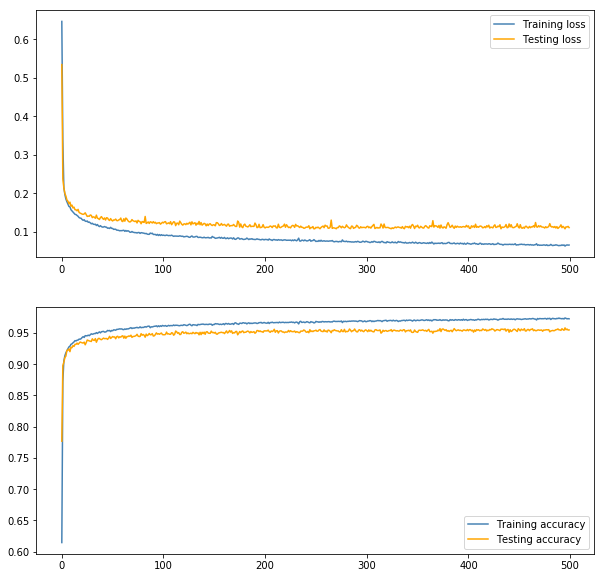

In [62]:
plot_learning_curve(ffnn_fitting.history)